In [1]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses


class AutoencoderModel(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder_layer = layers.Dense(latent_dim, activation="relu")
        self.decoder_layer = layers.Dense(784, activation="sigmoid")

    def encode(self, encoder_input):
        encoder_output = layers.Flatten()(encoder_input)
        encoder_output = self.encoder_layer(encoder_output)
        return encoder_output

    def decode(self, decoder_input):
        decoder_output = decoder_input
        decoder_output = self.decoder_layer(decoder_output)
        decoder_output = layers.Reshape((28, 28))(decoder_output)
        return decoder_output

    def call(self, x):
        return self.decode(self.encode(x))



In [3]:
import numpy as np

tf.random.set_seed(5)
np.random.seed(5)
autoencoder = AutoencoderModel(64)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(
    x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test)
)

autoencoder.evaluate(x_test, x_test)


Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0244 - val_loss: 0.0136
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0120 - val_loss: 0.0109
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 0.0090


0.009019359946250916

In [4]:
autoencoder.encode(x_test[:1])


<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[3.3981605 , 1.9101851 , 2.7859516 , 2.4481437 , 2.0692775 ,
        4.87715   , 2.1372266 , 0.        , 2.0753148 , 1.2593837 ,
        2.8385196 , 4.457389  , 0.10571915, 2.1499825 , 5.089861  ,
        3.4004195 , 3.9977999 , 0.86256313, 2.2539403 , 1.6323329 ,
        3.9234629 , 1.9165983 , 0.        , 2.0842078 , 2.1390944 ,
        0.98262405, 1.9557223 , 2.246275  , 3.472771  , 3.9070032 ,
        2.9521956 , 0.8399822 , 1.4248189 , 1.7349219 , 1.0491786 ,
        4.3570604 , 2.1615815 , 1.6781375 , 1.9274088 , 0.        ,
        1.9041014 , 3.4699976 , 3.4966543 , 2.6128798 , 1.6122469 ,
        1.5732343 , 3.8059182 , 0.        , 1.8187783 , 0.        ,
        2.1037915 , 5.901557  , 3.9409094 , 2.8554113 , 1.3464917 ,
        1.8130544 , 1.1144917 , 0.9243204 , 2.1040163 , 3.3831496 ,
        4.04688   , 3.889729  , 0.8093816 , 3.617434  ]], dtype=float32)>

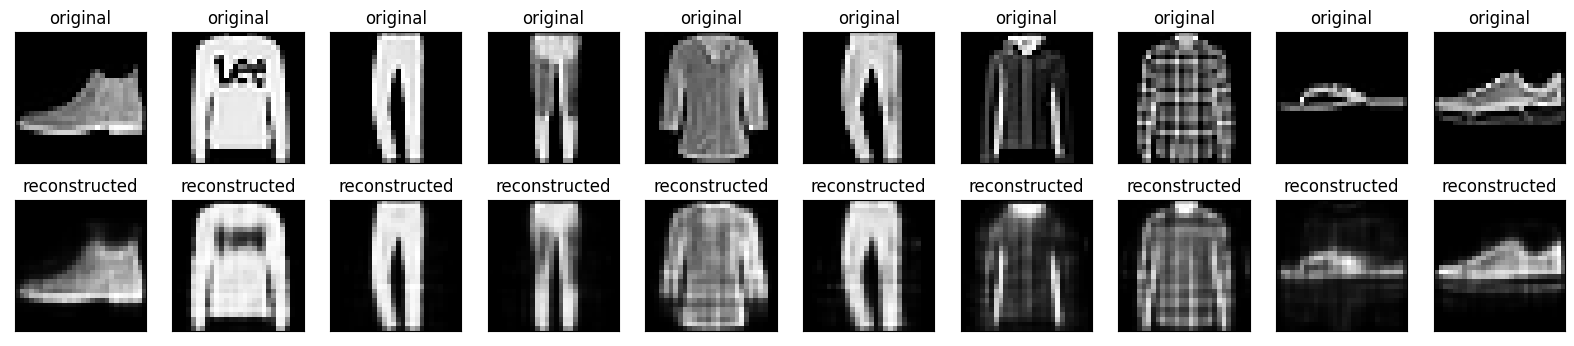

In [5]:
import matplotlib.pyplot as plt


def show_images(model, images):
    encoded_imgs = model.encode(images).numpy()
    decoded_imgs = model.decode(encoded_imgs).numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


show_images(autoencoder, x_test)


In [6]:
import keras_tuner
from tensorflow import keras
from keras_tuner import RandomSearch


class AutoencoderBlock(keras.Model):
    def __init__(self, latent_dim, hp):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder_layers = []
        for i in range(
            hp.Int("encoder_layers", min_value=0, max_value=2, step=1, default=0)
        ):
            self.encoder_layers.append(
                layers.Dense(
                    units=hp.Choice("encoder_layers_{i}".format(i=i), [64, 128, 256]),
                    activation="relu",
                )
            )
        self.encoder_layers.append(layers.Dense(latent_dim, activation="relu"))
        self.decoder_layers = []
        for i in range(
            hp.Int("decoder_layers", min_value=0, max_value=2, step=1, default=0)
        ):
            self.decoder_layers.append(
                layers.Dense(
                    units=hp.Choice("decoder_layers_{i}".format(i=i), [64, 128, 256]),
                    activation="relu",
                )
            )
        self.decoder_layers.append(layers.Dense(784, activation="sigmoid"))

    def encode(self, encoder_input):
        encoder_output = layers.Flatten()(encoder_input)
        for layer in self.encoder_layers:
            encoder_output = layer(encoder_output)
        return encoder_output

    def decode(self, decoder_input):
        decoder_output = decoder_input
        for layer in self.decoder_layers:
            decoder_output = layer(decoder_output)
        decoder_output = layers.Reshape((28, 28))(decoder_output)
        return decoder_output

    def call(self, x):
        return self.decode(self.encode(x))



In [7]:

def build_model(hp):
    latent_dim = 20
    autoencoder = AutoencoderBlock(latent_dim, hp)
    autoencoder.compile(optimizer="adam", loss="mse")
    return autoencoder


tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

tuner.search(x_train, x_train, epochs=10, validation_data=(x_test, x_test))


Trial 10 Complete [00h 01m 04s]
val_loss: 0.011433261446654797

Best val_loss So Far: 0.010884897783398628
Total elapsed time: 00h 10m 18s


Results summary
Results in my_dir/helloworld
Showing 1 best trials
Trial summary
Hyperparameters:
encoder_layers: 0
decoder_layers: 2
encoder_layers_0: 256
encoder_layers_1: 256
decoder_layers_0: 128
decoder_layers_1: 256
Score: 0.010884897783398628
313/313 [==============================] - 1s 1ms/step - loss: 0.0109


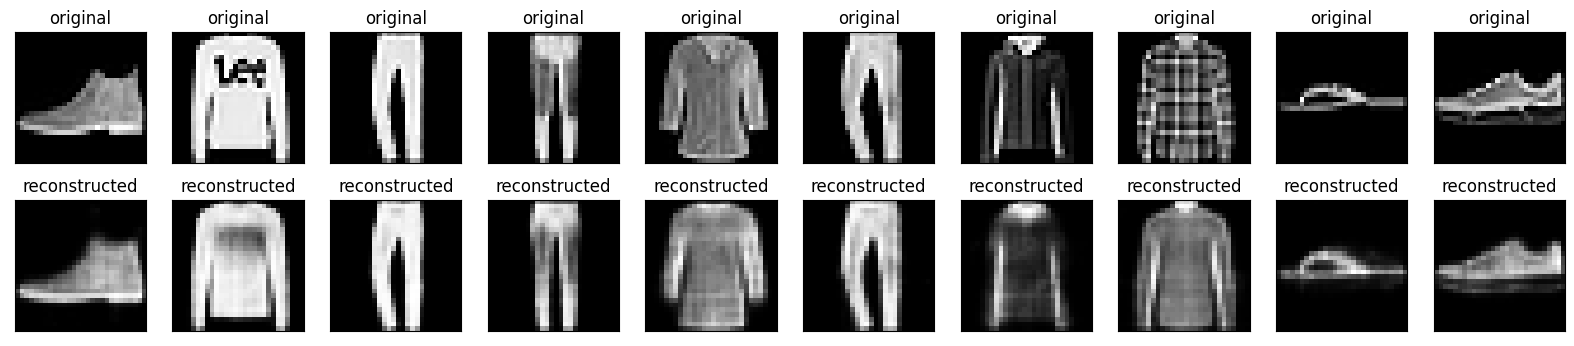

In [8]:
autoencoder = tuner.get_best_models(num_models=1)[0]
tuner.results_summary(1)
autoencoder.evaluate(x_test, x_test)

show_images(autoencoder, x_test)
